This notebook addresses a parallel machine scheduling problem with resource constraints. The objective studied is minimizing the completion time of latest task (makespan).

There is a set of tasks (with precedence relationships) and all tasks need to be performed on one of the machines. There is also a set of resources (with limited capacity) and certain resources are required for processing of certain tasks. Machines can only process one task at a given time and resource capacities cannot be exceeded.

This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
nbrOfTasks = 10
tasks = [*range(0, nbrOfTasks)] 

In [2]:
nbrOfMachines = 3
machines = [*range(0, nbrOfMachines)] 

In [3]:
import random
minProcessingTime=10
maxProcessingTime=40
processingTimes= [random.randint(minProcessingTime,maxProcessingTime) for t in tasks] 

In [4]:
nbrOfResources = 3
resources = [*range(0, nbrOfResources)] 

In [5]:
resourceCapacities = [random.randint(4,12) for r in resources]

In [6]:
resourceDemand = [[random.randint(0,4) for r in resources]  for t in tasks] 
print(resourceDemand)  # resourceDemand_list[t][r]

[[2, 4, 2], [4, 1, 1], [3, 4, 4], [4, 4, 2], [3, 1, 3], [3, 0, 3], [3, 2, 1], [3, 2, 4], [0, 4, 2], [2, 3, 1]]


In [7]:
#randomly generate successor tasks for each task
succ=[random.sample(range(t+1, nbrOfTasks), int(round((nbrOfTasks-t)/3))) for t in tasks] 
print(succ)

[[6, 9, 5], [4, 6, 7], [8, 4, 6], [6, 7], [8, 9], [7, 9], [7], [8], [9], []]


In [8]:
from docplex.cp.model import *
mdl = CpoModel(name='parallelMachineScheduling') 

In [9]:
# Create task interval variables
tasks_itv_vars = [mdl.interval_var(name="T{}".format(t), size=processingTimes[t]) for t in tasks]

In [10]:
# Minimize end of all tasks
mdl.add(mdl.minimize(mdl.max([mdl.end_of(t) for t in tasks_itv_vars])))

In [11]:
# Add precedence constraints
for t in range(nbrOfTasks):
    for s in succ[t]:
        mdl.add(mdl.end_before_start(tasks_itv_vars[t], tasks_itv_vars[s]))

In [12]:
# Capacity of resources cannot be exceeded
for r in range(nbrOfResources):
    resources = [mdl.pulse(tasks_itv_vars[t], resourceDemand[t][r]) for t in range(nbrOfTasks) if resourceDemand[t][r] > 0]
    mdl.add(mdl.sum(resources) <= resourceCapacities[r])

In [13]:
# tasks at a time cannot exceed number of machines
tasks_atATime=sum([pulse(tasks_itv_vars[t], 1) for t in range(nbrOfTasks)])
mdl.add(tasks_atATime<=nbrOfMachines)

In [14]:
msol= mdl.solve(log_output=True)

In [15]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 22, variables: integer: 0, interval: 10, sequence: 0
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.51 sec
-------------------------------------------------------------------------------
Objective values: (201,), bounds: (201,), gaps: (0,)
T0: (start=0, end=20, size=20, length=20)
T1: (start=20, end=51, size=31, length=31)
T2: (start=74, end=85, size=11, length=11)
T3: (start=0, end=38, size=38, length=38)
T4: (start=85, end=120, size=35, length=35)
T5: (start=38, end=74, size=36, length=36)
T6: (start=85, end=112, size=27, length=27)
T7: (start=120, end=149, size=29, length=29)
T8: (start=149, end=166, size=17, length=17)
T9: (start=166, end=201, size=35, length=35)


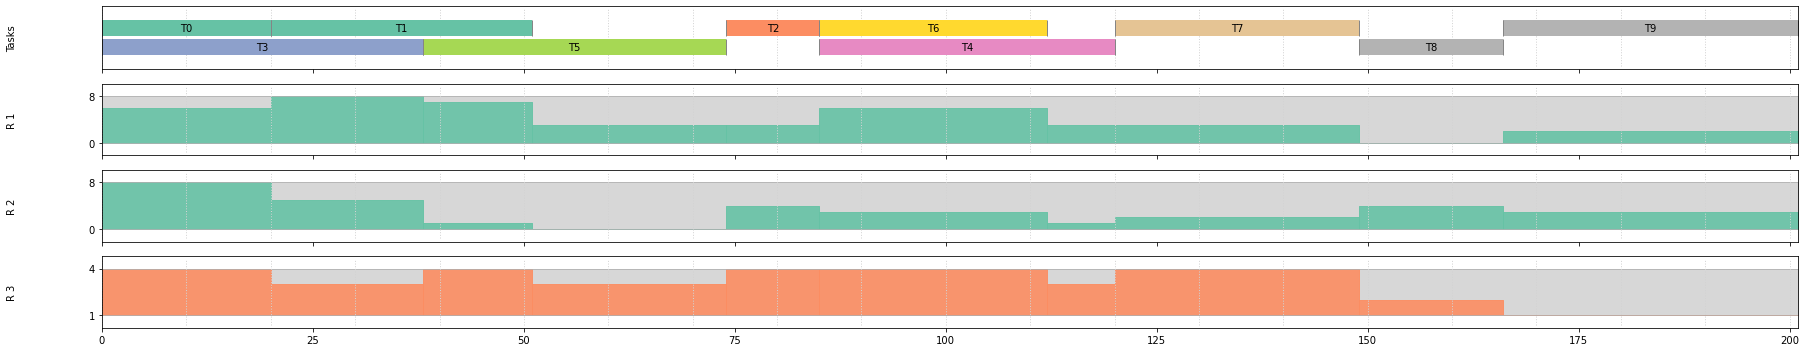

In [16]:
# Solve model
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

if msol and visu.is_visu_enabled():
    load = [CpoStepFunction() for j in range(nbrOfResources)]
    for i in range(nbrOfTasks):
        itv = msol.get_var_solution(tasks_itv_vars[i])
        for j in range(nbrOfResources):
            if 0 < resourceDemand[i][j]:
                load[j].add_value(itv.get_start(), itv.get_end(), resourceDemand[i][j])

    visu.timeline("Solution for RCPSP ")
    visu.panel("Tasks")
    for i in range(nbrOfTasks):
        visu.interval(msol.get_var_solution(tasks_itv_vars[i]), i, tasks_itv_vars[i].get_name())
    for j in range(nbrOfResources):
        visu.panel("R " + str(j + 1))
        visu.function(segments=[(INTERVAL_MIN, INTERVAL_MAX, resourceCapacities[j])], style='area', color='lightgrey')
        visu.function(segments=load[j], style='area', color=j)
    visu.show()